In [1]:
#import modules
from pandas import *
from matplotlib import *
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
options.display.max_columns = 100
# import seaborn
# import seaborn as sns
# import re
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
#Importing my own packages which may contain some bugs
# import Energy_Calc
# import ThermoProp
import AHU1_Env
#Will reload them in a separate cell so that new changes to the module can be easily defined

In [3]:
#Only need to rerun this cell this if I make changes to Energy_Calc and other
#modules
# importlib.reload(Energy_Calc)
# from Energy_Calc import Energy_Calc
# importlib.reload(ThermoProp)
# from ThermoProp import *
importlib.reload(AHU1_Env)
from AHU1_Env import *

In [4]:
env = Env()        

/isis/home/nauga/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/isis/home/nauga/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [5]:
np.random.seed(100)
env.seed(100)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

In [6]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(32))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('tanh'))
print(actor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                192       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
__________

In [7]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 1, 5)         0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 5)            0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 6)            0           action_input[0][0]               
                                                                 flatten_2[0][0]                  
__________

In [8]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(theta=.15, mu=0., sigma=.3, size=nb_actions)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  gamma=.99, target_model_update=1e-3)#random_process=random_process, 
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

In [9]:
from keras.callbacks import Callback
import os
class saveBest(Callback):
    def __init__(self):
        self.lastreward = -200
        self.rewardsTrace = []
    def on_episode_end(self, episode, logs={}):
        self.rewardsTrace.append(logs.get('episode_reward'))
        if logs.get('episode_reward')>self.lastreward:          
            previousWeights = 'Q1checkpoint_reward_{}.h5f'.format(self.lastreward)
            if os.path.exists(previousWeights): os.remove(previousWeights)
            self.lastreward = logs.get('episode_reward')
            print("The reward is higher than the best one, saving checkpoint weights")
            newWeights = 'Q1checkpoint_reward_{}.h5f'.format(logs.get('episode_reward'))
            self.model.save_weights(newWeights, overwrite=True)

In [10]:
bestwts = saveBest()
agent.fit(env, nb_steps=50000, visualize=False, verbose=1, callbacks=[bestwts])#, nb_max_episode_steps=200)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 76s 8ms/step - reward: 1.0528
2 episodes - episode_reward: 3883.250 [2805.500, 4961.000] - loss: 0.098 - mean_absolute_error: 0.368 - mean_q: 6.306

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 75s 8ms/step - reward: 1.4007
2 episodes - episode_reward: 5559.500 [5539.500, 5579.500] - loss: 0.112 - mean_absolute_error: 0.298 - mean_q: 18.316

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 75s 8ms/step - reward: 1.4326
3 episodes - episode_reward: 5702.500 [5655.500, 5739.000] - loss: 0.142 - mean_absolute_error: 0.268 - mean_q: 30.278

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 75s 8ms/step - reward: 1.4490
2 episodes - episode_reward: 5784.000 [5783.000, 5785.000] - loss: 0.271 - mean_absolute_error: 0.259 - mean_q: 41.242

Interval 5 (40000 steps performed)
10000/10000 [

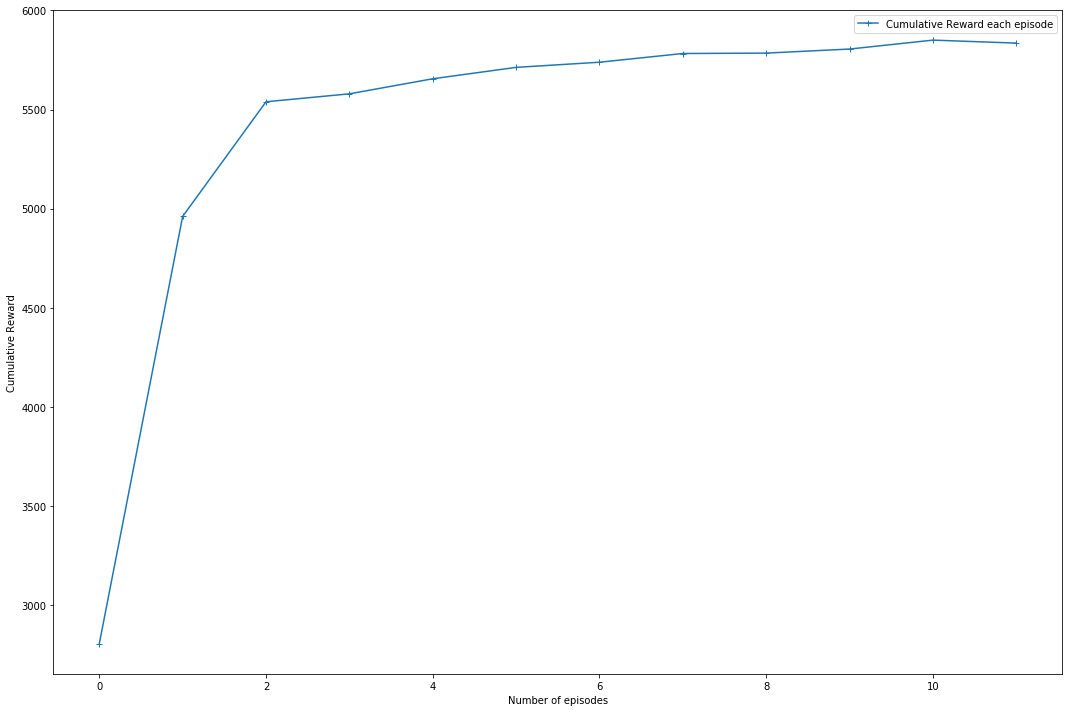

In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [15.0,10.0]
fig = plt.figure()
ax = plt.subplot(111)
#ax.plot(agent.rewardOP,'+-',label='Cumulative Reward each episode')
ax.plot(bestwts.rewardsTrace,'+-',label='Cumulative Reward each episode')
plt.xlabel('Number of episodes')
plt.ylabel('Cumulative Reward')
#plt.title('Performance Curve for the DDPG agent in the Aggregate Building Energy Environment')
plt.tight_layout()
plt.legend()
plt.show()

In [10]:
from keras.callbacks import Callback
class actionSequence(Callback):
    def on_episode_begin(self, episode, logs={}):
        self.actionSeq = []
        
    def on_step_end(self, step, logs={}):
        self.actionSeq.append(logs.get('action'))
agent.load_weights('Q1checkpoint_reward_5850.5.h5f')

In [11]:
actionList = actionSequence()
result = agent.test(env, nb_episodes=1, visualize=False,verbose=0,callbacks=[actionList])

controlledAction = actionList.actionSeq

In [12]:
len(env.EnergyCons)

4001

In [13]:
orginalEnergy = [i[1] for i in env.EnergyCons]
controlledEnergy = [i[0] for i in env.EnergyCons]

<IPython.core.display.Javascript object>


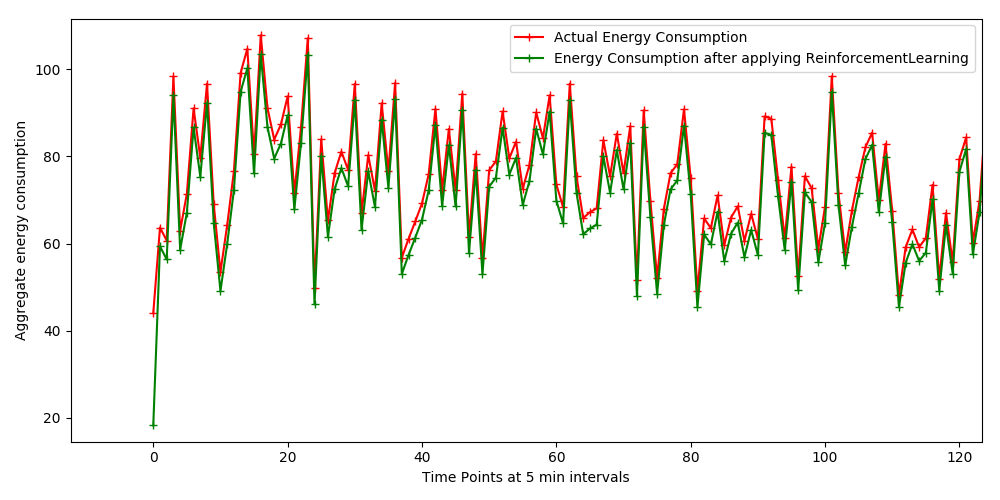

In [34]:
import matplotlib
#%matplotlib inline
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [10.0,5.0]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(orginalEnergy,'r+-',label='Actual Energy Consumption')
ax.plot(controlledEnergy,'g+-',label='Energy Consumption after applying ReinforcementLearning')
plt.xlabel('Time Points at 5 min intervals')
plt.ylabel('Aggregate energy consumption')
#plt.title('Comparison of Energy Consumption for buidling controller vs Reinforcement Learning Controller')
plt.tight_layout()
plt.legend()
plt.show()

In [26]:
t1 = ((np.array(orginalEnergy)-np.array(controlledEnergy))**1).mean()
t2 = np.average(np.array(orginalEnergy))
print ('Percentage Savings')
print (100*t1/t2)
print ('Energy Savsings in BTUs/Kg of dry air')
print (t1/1.055)

Percentage Savings
4.891511962055009
Energy Savsings in BTUs/Kg of dry air
3.2695336784698785


<IPython.core.display.Javascript object>


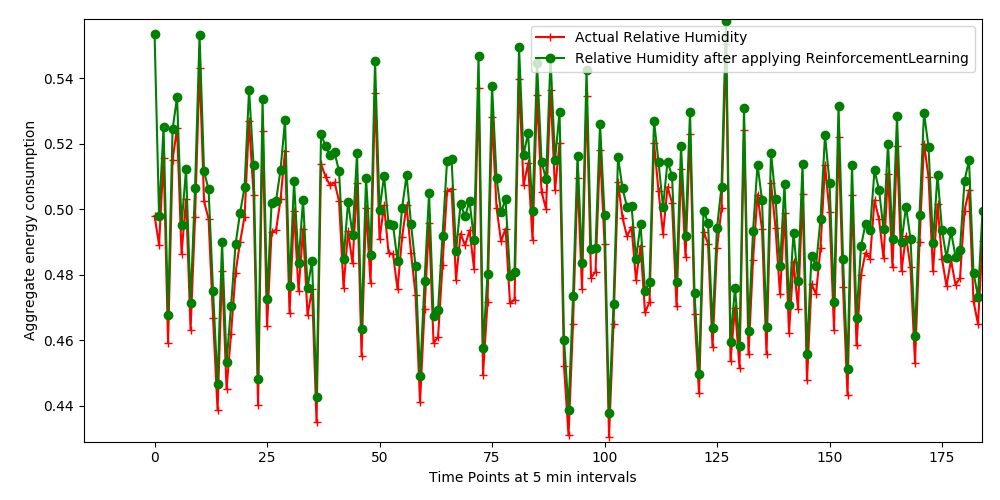

In [33]:
import matplotlib
#%matplotlib inline
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [10.0,5.0]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(env.relHum_original,'r+-',label='Actual Relative Humidity')
ax.plot(env.relHum_controlled,'go-',label='Relative Humidity after applying ReinforcementLearning')
plt.xlabel('Time Points at 5 min intervals')
plt.ylabel('Aggregate energy consumption')
#plt.title('Comparison of Energy Consumption for buidling controller vs Reinforcement Learning Controller')
plt.tight_layout()
plt.legend()
plt.show()

In [20]:
controlledAction = list(map(lambda x : env.boundsMapper(x)[1], controlledAction))

<IPython.core.display.Javascript object>


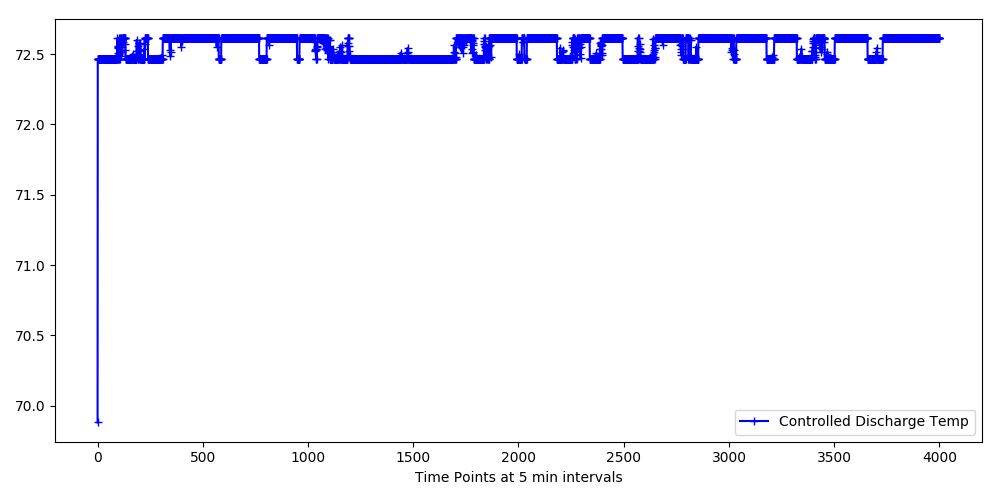

In [28]:
import matplotlib
%matplotlib notebook
#%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10.0,5.0]
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(controlledAction,'b+-',label='Controlled Discharge Temp')
plt.xlabel('Time Points at 5 min intervals')
plt.tight_layout()
plt.legend()
plt.show()